In [ ]:
!pip install control
!pip install tbcontrol

In [ ]:
# Módulos
import numpy as np
import control as ct
import controle as ctl
# Simulação Ideal da Planta
NT = 18             # Emanuel(7) + Staub(5) + Araldi(6)
R1 = NT*2e3         # Resistência de Entrada
R2 = 18e3           # Resistência do Circuito RC
C1 = 100e-9         # Capacitância do Circuito RC
C2 = 680e-9         # Capacitância do Ampop
####
z  = (C1*R2+C1*R1)/(2*C1*C2*R1*np.sqrt(1/(C1*C2*R1*R2))*R2)
w2 = 1/(C1*C2*R1*R2)
w  = np.sqrt(w2)
####
print("ζ: ", round(z, 3))# Cálculo de Valores Importantes do Circuito
Mp = np.exp(-np.pi*z/np.sqrt(1-z**2))
Tp = np.pi/(w*np.sqrt(1-z**2))
τ  = 1/(z*w)
Ts = 4*τ
####
Tp_ms = 1e3*Tp
####
print("Mp: ", round(Mp*100, 3), "%")    # Simulado: 24.698%
print("Tp: ", round(Tp*1e3, 3), "ms")   # Simulado: 22.80 ms
print("τ : ", round(τ*1e3 , 3), "ms")   # Simulado: NA
print("Ts: ", round(Ts*1e3, 3), "ms")   # Simulado: 55.82 ms (difícil determinar, mas entre ~56 e ~69)
print("ω: ", round(w, 3))

ζ:  0.407
Mp:  24.69 %
Tp:  22.828 ms
τ :  16.32 ms
Ts:  65.28 ms
ω:  150.646


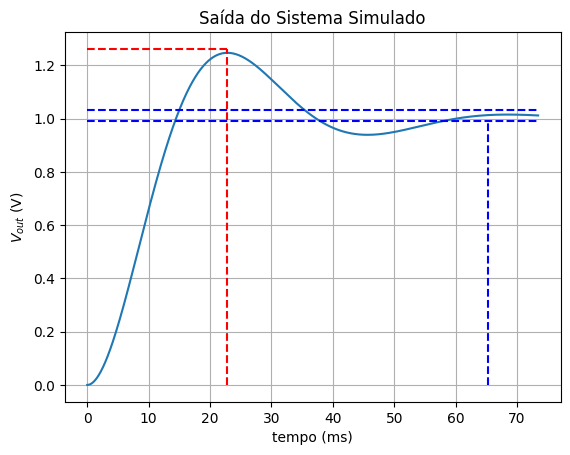

In [ ]:
import matplotlib.pyplot as plt
import control as ct

s = ct.tf('s')
t = np.linspace(0, (Ts+τ/2), 1000)  # t = tempo de acomodação 2% + meia constante de tempo
G = w2/(s**2 + s*2*z*w + w2)
t, y = ct.step_response(G, T=t)
tms  = 1e3*t
plt.plot(tms, y)
plt.xlabel("tempo (ms)")
plt.ylabel("$V_{out}$ (V)")
plt.title("Saída do Sistema Simulado")
## Plotando tempo de pico, tempo do acomodamento e sobressinal ##
plt.plot(tms[t<=Tp], y[-1]*(1+Mp)*np.ones(len(tms[t<=Tp])), 'r--')
plt.plot([Tp*1e3, Tp*1e3], [0, y[-1]*(1+Mp)], 'r--')

ys  = y[np.abs(y - y[-1]*(1-2e-2)) <= 1e-5]
plt.plot([Ts*1e3, Ts*1e3], [0, ys[0]], 'b--')
plt.plot(tms, np.ones(len(y))*y[-1]*(1-2e-2), 'b--')    # Limite inferior para 2%
plt.plot(tms, np.ones(len(y))*y[-1]*(1+2e-2), 'b--')    # Limite superior para 2%

plt.grid(True, 'both')
plt.savefig("Analogico.svg", format="svg")

## Simulação da Planta com Valores Reais

In [ ]:
Mp = 168e-3     # Pico-Final
yf = 500e-3     # Final
Tp = 17.60e-3   # Tempo de pico
Mp = Mp/yf      # Sobresinal em Porcentagem
####
ζ   = -np.log(Mp)/np.sqrt(np.pi**2 + np.log(Mp)**2)
ω   = np.pi/(Tp*np.sqrt(1-ζ**2))
τ   = 1/(ζ*ω)
Ta  = 4*τ     # Tempo de acomodação de 2%
ω2  = ω**2    # Conveniência
####
print("ζ:", ζ)
print("ω:", ω)
print("τ:", τ)
print("#####")
print("Ta:", Ta*1e3, "ms")

ζ: 0.32796159714045775
ω: 188.95021976249527
τ: 0.01613725292520876
#####
Ta: 64.54901170083505 ms


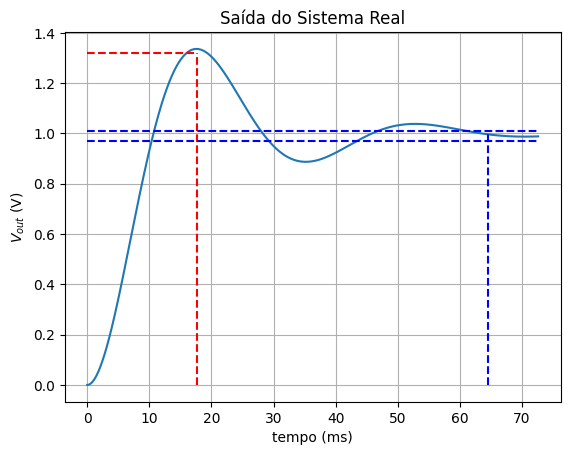

In [ ]:
## Reconstruindo Saída da Planta
s = ct.tf('s')
t = np.linspace(0, (Ta+τ/2), 1000)  # t = tempo de acomodação 2% + meia constante de tempo
G = ω2/(s**2 + s*2*ζ*ω + ω2)
t, y = ct.step_response(G, T=t)
tms  = 1e3*t
plt.plot(tms, y)
plt.xlabel("tempo (ms)")
plt.ylabel("$V_{out}$ (V)")
plt.title("Saída do Sistema Real")
## Plotando tempo de pico, tempo do acomodamento e sobressinal ##
plt.plot(tms[t<=Tp], y[-1]*(1+Mp)*np.ones(len(tms[t<=Tp])), 'r--')
plt.plot([Tp*1e3, Tp*1e3], [0, y[-1]*(1+Mp)], 'r--')

ya  = y[np.abs(y - y[-1]*(1+2e-2)) <= 7e-5]
plt.plot([Ta*1e3, Ta*1e3], [0, ya[0]], 'b--')
plt.plot(tms, np.ones(len(y))*y[-1]*(1-2e-2), 'b--')    # Limite inferior para 2%
plt.plot(tms, np.ones(len(y))*y[-1]*(1+2e-2), 'b--')    # Limite superior para 2%

plt.grid(True, 'both')

## Design do Controlador

0 states have been removed from the model


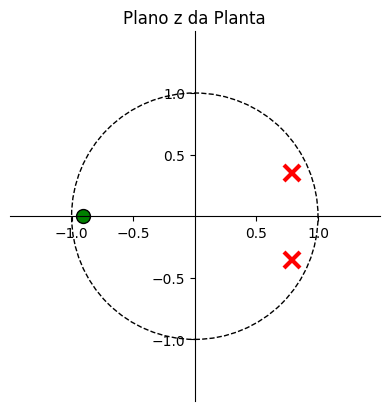

In [ ]:
## Características Desejadas do Sistema Controlado
Mpc = 2e-2*7
Tac = NT*1e-3 # p/ 5%
####
zc  = -np.log(Mpc)/np.sqrt(np.pi**2 + np.log(Mpc)**2)
wc  = 3/(zc*Tac)
wdc = wc*np.sqrt(1-zc**2)
Ts  = 2*np.pi/(wdc*10)    ## Seguindo Regra Geral
####
j  = complex(0, 1)
s1 = -zc*wc+j*wdc
z1 = np.exp(s1*Ts)
####
Gz  = ct.minreal(ct.c2d(G, Ts))
[[[b]], [[a]]] = ct.tfdata(Gz)
ctl.zplane(Gz, title="Plano z da Planta")
plt.show()

0 states have been removed from the model


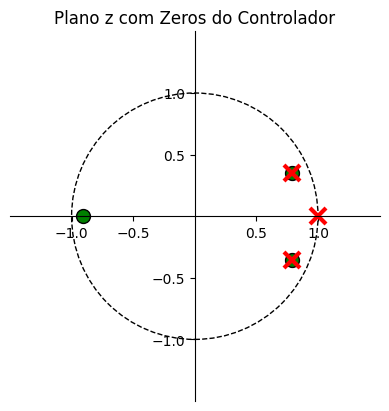

2 states have been removed from the model


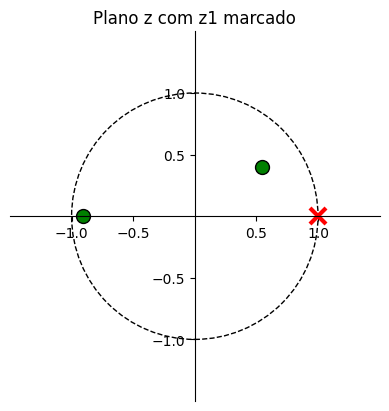

In [ ]:
## Cancelando Polos da Planta
z     = ct.tf('z')
alpha = ct.minreal(Gz).poles()
Cz    = 1/(z-1)
for bc in alpha:
  Cz = Cz * (z-bc)
CGz = Cz*Gz
ctl.zplane(CGz, title="Plano z com Zeros do Controlador")
CGz = ct.minreal(CGz)
ctl.zplane((z-z1)*CGz, title="Plano z com z1 marcado")
plt.show()

## Ajustando C(z) por Root Locus

(1.0000000000000013+0j)
fi1: -123.5809653927774 °
fi2: -303.5809653927774 °
0 states have been removed from the model
0 states have been removed from the model


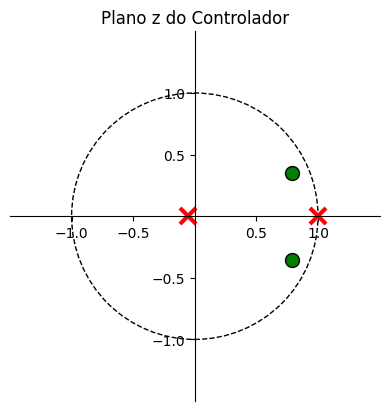

α: [0.7884894+0.35319678j 0.7884894-0.35319678j]
β: 0.051499230302002985
K: 3.2302790599342854
<TransferFunction>: sys[1572]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


z^2 - 1.577 z + 0.7465
-----------------------
z^2 - 0.9485 z - 0.0515



In [ ]:
fi1 = 0
for zero in CGz.zeros():
    fi1 = fi1 + np.arctan2(z1.imag - zero.imag, z1.real - zero.real)
for pole in CGz.poles():
    fi1 = fi1 - np.arctan2(z1.imag - pole.imag, z1.real - pole.real)
    print(pole)
##
print("fi1:", (180/np.pi)*fi1, "°")
#fi1 = np.arctan2(-alpha.real[0] - z1.real, z1.imag-alpha.imag[0])
#print("fi1:", (180/np.pi)*fi1, "°")
fi2 =  np.pi+fi1
print("fi2:", (180/np.pi)*fi2, "°")
# fi2 = np.arctan2(-β.real - z1.real, z1.imag+β.imag)
# np.tan(fi2) = (-β - z1.real)/(z1.imag-0)
# z1.imag*np.tan(fi2) = -β - z1.real
# β = -(z1.imag*np.tan(fi2) + z1.real)
β   = -(z1.imag * np.tan(-fi2) + z1.real) # => Adição angular de um polo é invertida
# β   = (z1.imag - z1.real * np.tan(-fi2))/np.tan(fi2)
Cz  = ct.minreal(Cz/(z+β))
CGz = ct.minreal(CGz/(z+β))
ctl.zplane(Cz, title="Plano z do Controlador")
plt.show()
#################################
#        b[0] + ... + b[n]z**-n #
# G(z) = ---------------------- #
#        a[0] + ... + a[n]z**-n #
#################################
#
#|K * C(z)G(z)|z->z1=1
#|K * C(z1)G(z1)| = 1
#
#     |     1    |
# K = |----------|
#     |C(z1)G(z1)|
#
[[[b]], [[a]]] = ct.tfdata(CGz)
K   = np.abs(np.polyval(a, z1)/np.polyval(b, z1))
# Ajustando ganho do integrador
print("α:", alpha)
print("β:", β)
print("K:", K)
print(Cz)

/usr/local/lib/python3.10/dist-packages/control/statesp.py:2170: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


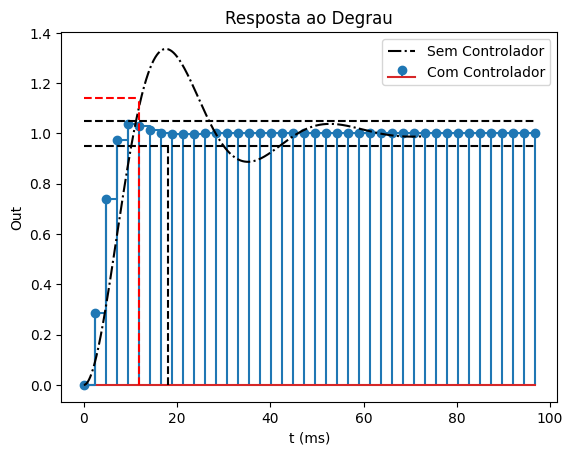

In [ ]:
FTMF = ct.feedback(K*CGz, 1)
axcg, tcg, ycg = ctl.plot_step(FTMF, t=np.arange(0, Ta+2*τ, Ts),
                               label = "Com Controlador")
axcg.plot(t*1e3, y, "k-.", label="Sem Controlador")

Mpcg = np.exp(-np.pi*zc/np.sqrt(1-zc**2))
Tpcg = np.pi/(wc*np.sqrt(1-zc**2))
τcg  = 1/(zc*wc)
Tscg = 3*τcg

plt.plot(1e3*(tcg[tcg<=Tpcg]), 1*(1+Mpcg)*np.ones(len(tcg[tcg<=Tpcg])), 'r--')
plt.plot([Tpcg*1e3, Tpcg*1e3], [0, 1*(1+Mpcg)], 'r--')

yscg  = ycg[np.abs(ycg - 1*(1-5e-2)) <= 1e-5]
plt.plot([Tscg*1e3, Tscg*1e3], [0, 1*(1-5e-2)], 'k--')
plt.plot(tcg*1e3, np.ones(len(ycg))*1*(1-5e-2), 'k--')    # Limite inferior para 5%
plt.plot(tcg*1e3, np.ones(len(ycg))*1*(1+5e-2), 'k--')    # Limite superior para 5%

plt.grid(True, 'both')
plt.legend()
plt.grid()
plt.show()

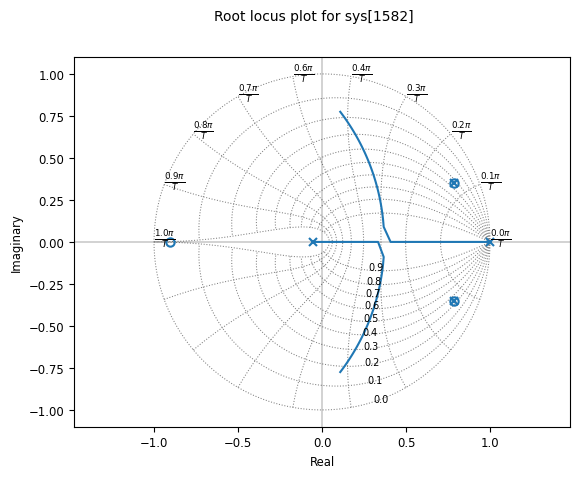

/usr/local/lib/python3.10/dist-packages/control/xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
/usr/local/lib/python3.10/dist-packages/control/xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


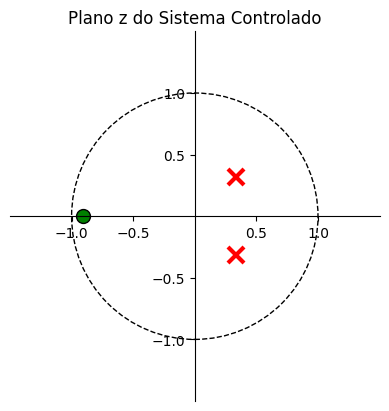

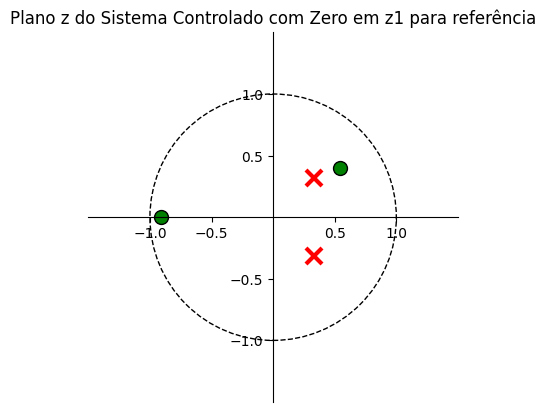

Pólos da FTMF: [0.33067447+0.31541433j 0.33067447-0.31541433j]
z1: (0.5459881936760765+0.39668364249449717j)


In [ ]:
k = np.linspace(0, K+5, 100)
ct.root_locus(Cz*Gz, k)
plt.show()

ctl.zplane(FTMF, title="Plano z do Sistema Controlado")
ctl.zplane((z-z1)*FTMF, title="Plano z do Sistema Controlado com Zero em z1 para referência")
plt.show()

print("Pólos da FTMF:", FTMF.poles())
print("z1:", z1)

In [ ]:
print(FTMF.poles())
print(z1)

[0.33067447+0.31541433j 0.33067447-0.31541433j]
(0.5459881936760765+0.39668364249449717j)


In [ ]:
Mpcg  = (np.max(ycg) - 1)/1
Tpcg  = tcg[ycg==np.max(ycg)][0]
yfcg  = np.flip(ycg)  # Saída invertida (trás para frente)
yfscg = yfcg[np.abs(yfcg-1*(1-5e-2)) < 1e-2][0]   # último y de 5%
Tscg  = tcg[ycg==yfscg][0]
τcg   = Tscg/3
ζc    = -np.log(Mpcg)/np.sqrt(np.pi**2+np.log(Mpcg)**2) #ζ do sistema compensado
ωc    = np.pi/(Tpcg*np.sqrt(1-ζc**2))                   #ω do sistema compensado

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Apresentação dos Resultados
print("Características do Sistema Compensado")
print("Mp: ", round(Mpcg*100, 3), "%")
print("tp: ", round(Tpcg*1e3, 3), "ms")
print("τ : ", round(τcg*1e3 , 3), "ms")
print("Ts: ", round(Tscg*1e3, 3), "ms")
print("ζ : ", round(ζc, 3))
print("ω : ", round(ωc, 3), "rad/s")
# Comparação com Resultados Desejados
print("")
print("Erro em relação ao valor desejado:")
print("Mp: ", round(100*(Mpcg-Mp)/Mp, 3), "%")
print("Ts: ", round(100*(Tscg-Ts5)/Ts5, 3), "%")
print("ζc: ", round(100*(ζc-ζ)/ζ, 3), "%")
print("ωc: ", round(100*(ωc-ω)/ω, 3), "%")

In [ ]:
ctl.plot_step(Cz*Cz2, t=tcg, title="Resposta ao Degrau do Microcontrolador")
plt.show()

## Implementação Da Equação Recursiva do Microcontrolador

In [ ]:
import scipy.signal as sp

b = Gz.num[0][0]
a = Gz.den[0][0]

print("b =", b)
print("a =", a)
# Verificando Coeficientes
tz = np.arange(-len(a)*Ta, (Ts+2*τ), Ta)
u  = np.heaviside(tz, 0) # degrau
ua = 0 # Acumula b[0]*x[k] + ... + b[n]*x[k-n]
ya = 0 # Acumula a[1]*y[k-1] + ... + a[n]*y[k-n]
yf = np.zeros(len(tz))
n0 = len(a)
for n in range(n0, len(tz)): # i = n-max(len(a), len(b))
    j = 0
    ua=0
    ya=0
    for bn in b:
        ua = ua + bn*x[n-j]
        j  = j+1
    j = 1
    for an in a[1:]:
        ya = ya + an*yf[n-j]
        j = j+1
    yf[n] = (ua-ya)/a[0]
    n = n+1

plt.stem(tz, u, label="$V_{in}$")
plt.stem(tz, yf, "r", label="$V_{out}$")
plt.plot(t, y, "k", label="$V_{out}$ contínuo")
plt.legend()
plt.show()